# PID

There's a lot of folklore out there about PID control. Keep in mind that folklore arises in specific contexts, so the challenge is to separate the broadly applicable aspects of the folklore and the aspects of the folklore specific to the context in which it arose.

Never forget that underneath the control systems are differential equations. Pay close attention to the link between the Laplace representation and the differential equation.

We'll make extensive use of the Laplace transform. The Laplace transform converts the system into a representation in the the complex domain, often called the S-domain.

\begin{align}
\frac{dx}{dt} &\Leftrightarrow sX(s)-x(0) \\
\frac{d^2x}{dt^2} &\Leftrightarrow s^2X(s)-sx(0)-x'(0) \\
&\cdots \\
\frac{d^nx}{dt^n} &\Leftrightarrow s^nX(s)-s^{n-1}x(0)-s^{n-2}x'(0)-\ldots-sx^{(n-2)}(0)-x^{(n-1)}(0) \\
\end{align}

To simplify, we'll assume 0 initial conditions. That is, $x$ and all its time derivatives are $0$ so that $x(0)=0, x'(0)=0,\ldots,x^{(i)}(0)=0$.

General setup is that we have a controller and a plant. 

![control_setup](figures/control_setup.svg)

$$x=f(x,x_d)$$

We're going to test with control input functions including the impulse, a unit step, and sin wave. An impulse is pretty unrealistic, but it's mathematically insightful as it captures the important aspects of the system's behavior.

Another thing we can check is whether there will be steady state value for the system using the final value theorem:

$$\lim_{t\rightarrow\infty}f(t)=\lim_{s\rightarrow0}sF(s)$$

What is the meaning of a pole or zero? The effectiveness of a PID controller depends almost entirely on the plant being controlled. Characterize the plant and you can design the controller.

What are other control strategies?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

# P control

![control_setup](figures/controller_kp_plant_first_order_time_domain.svg)

\begin{align}
\frac{dx}{dt} &= k_px_d - k_px
\end{align}

![control_setup](figures/controller_kp_plant_first_order_s_domain.svg)

-----


## $\frac{1}{s}$ plant

Converting to the s-domain with the Laplace transform...

\begin{align}
sX &= k_pX_d - k_pX \\
(s+k_p)X &= k_pX_d \\
X &= \frac{k_p}{s+k_p}X_d \\
\end{align}

### $x_d=\delta(t)\Leftrightarrow1$ input

With input set to a delta function,

\begin{align}
X &= \frac{k_p}{s+k_p} \\
x(t) &= k_pe^{-k_pt}
\end{align}

we see the plant state return to 0 exponentially with speed controlled by $k_p$

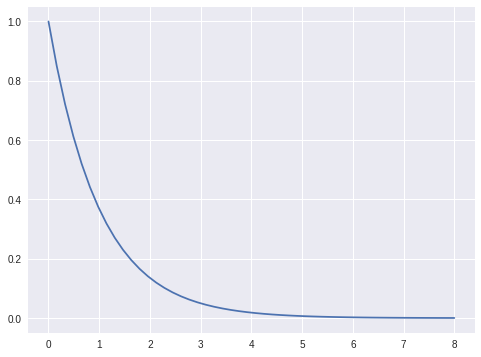

In [2]:
t = np.linspace(0, 8)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(t, np.exp(-t))

In [25]:
from scipy.signal import (
    ZerosPolesGain,
    impulse, impulse2,
    step, step2,
    lsim, lsim2,
    bode
)

from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from abc import ABC, abstractmethod

output_notebook()


Loading BokehJS ...

In [42]:
class PControllerSPlant(object):
    """Provides a p controller and 1/s plant

           kp 
    H(s)= ----
          s+kp
    """
    def __init__(self, sys):
        self.sys = sys
        self.update_kwargs = {'kp':(0.1, 3., 0.1)}
    def update(self, kp):
        self.sys.poles = [-kp]
        self.sys.gain = kp
    

In [44]:
def analyze_lti(lti, t=np.linspace(0,10,100)):
    """Create a set of plots to analyze an lti system
    
    """
    t_impulse, y_impulse = impulse(lti.sys)
    fig_impulse = figure(title="impulse response", x_range=(0, 10), y_range=(-0.1, 3), x_axis_label=r'$$time$$')
    g_impulse = fig_impulse.line(x=t_impulse, y=y_impulse)

    t_step, y_step = step(lti.sys)
    fig_step = figure(title="step response", x_range=(0, 10), y_range=(-0.04, 1.04))
    g_step = fig_step.line(x=t_step, y=y_step)
    
    fig_pz = figure(title="pole-zero plot", x_range=(-4, 1), y_range=(-2,2))
    g_poles = fig_pz.circle(x=lti.sys.poles.real, y=lti.sys.poles.imag, size=10, fill_alpha=0)
    g_rootlocus = fig_pz.line(x=[0, -10], y=[0, 0], line_color='red')

    def update(**kwargs):
        lti.update(**kwargs)
        g_impulse.data_source.data['x'], g_impulse.data_source.data['y'] = impulse(lti.sys, T=t)
        
        g_step.data_source.data['x'], g_step.data_source.data['y'] = step(lti.sys, T=t)
        
        g_poles.data_source.data['x'] = lti.sys.poles.real
        g_poles.data_source.data['y'] = lti.sys.poles.imag
        push_notebook()

    grid = gridplot(
        [fig_impulse, fig_step],
        [fig_pz, None],
        plot_width=300, plot_height=300
    )

    show(grid, notebook_handle=True)

    interact(update, **lti.update_kwargs)

sys = PControllerSPlant(ZerosPolesGain([], [-1], [1]))
analyze_lti(sys)

In [ ]:
sys = ZeroPolesGain(poles=[-1], zeros=[], gain=[1])
analyze_lti(poles=[-1], zeros=[], gain=[1])

### $x_d=u(t)\Leftrightarrow\frac{1}{s}$ input

With input set to a unit step function

\begin{align}
X &= \frac{k_p}{s+k_p}\frac{1}{s} \\
\end{align}

Do the partial fraction expansion

\begin{align}
\frac{k_p}{s+k_p}\frac{1}{s} &= \frac{a}{s+k_p} + \frac{b}{s} \\
\end{align}

so 

\begin{align}
 k_p &= as + b(s+k_p) \\
\end{align}

setting $s=0$ and solving for $b$,

$$b=1$$

setting $s=-k_p$ and solving for $a$,

$$a=-1$$

so overall

\begin{align}
X &= -\frac{1}{s+k_p} + \frac{1}{s} \\
x(t) &= -e^{-k_pt} + u(t) \\
 &= u(t) - e^{-k_pt} \\
\end{align}

$x$ exponentially approaches the control step input with speed controlled by $k_p$! Make $k_p$ larger and it will converge faster. Make $k_p$ negative and the system will explode!

[would be fun to have an interactive slider plot]

In [ ]:
t = np.linspace(0, 8)
xd = t>=0
x = -np.exp(-t) + xd
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(t, xd)
ax.plot(t, x)

### $x_d=\sin(t)\Leftrightarrow\frac{1}{s^2+1}$ input

$$\frac{dx}{dt}=-k_px+k_p\sin(t)$$

$$X=\frac{k_p}{s+k_p}\frac{1}{s^2+1}$$

Solve with Laplace or method of undertermined coefficients.

\begin{align}
x(t) &= \frac{k_p}{k_p^2+1}\left(k_p\sin(t)-\cos(t)+e^{-k_pt}\right)
\end{align}

In [ ]:
# kp=1
t = np.linspace(0, 20, 100)
xd = np.sin(t)
x = (np.sin(t)-np.cos(t) + np.exp(-t))/2.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(t, xd)
ax.plot(t, x)

The system settles in to a sin wave following the input signal with a phase shift and attenuation.

-----

## $\frac{1}{s^2}$ plant

The $\frac{1}{s}$ plant is unrealistic in the setting of a mechanical system because we cannot change velocities directly. (Can we do this electrically?). We can only apply a force. Force and displacement are related via the acceleration and velocity. So a $\frac{1}{s^2}$ plant is more realistic.

$$s^2X=k_pX_d-k_pX$$

after rearrangement,

$$X=\frac{k_p}{s^2+k_p}X_d$$

see how increasing the degree of the plant increased the degree of the $s$ term in the denominator.

### $x_d=\delta(t)\Leftrightarrow1$ input

\begin{align}
X &= \frac{k_p}{s^2+k_p} \\
x(t) &= \sqrt{k_p}\sin\left(\sqrt{k_p}\ t\right) \\
\end{align}

In [ ]:
t = np.linspace(0, 8)
x = np.sin(t)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(t, x)

The impulse just kicks off the system and it oscillates forever.

### $x_d=u(t)\Leftrightarrow\frac{1}{s}$ input

\begin{align}
X &= \frac{k_p}{s^2+k_p}\frac{1}{s} \\
\end{align}

\begin{align}
\frac{k_p}{s^2+k_p}\frac{1}{s} &= \frac{as+b}{s^2+k_p} + \frac{c}{s} \\
k_p &= (as+b)s + c(s^2+k_p) \\
\end{align}

set $s=0$ and solve for $c$

$$c=1$$

plug in the value of $c$ and expand the right hand side

\begin{align}
k_p &= as^2+bs + s^2+k_p \\
0 &= (a+1)s^2+bs \\
\end{align}

comparing like terms, we see that there are no $s^2$ or $s$ terms on the left-hand side, so

\begin{align}
0 &= a+1 \\
a &= -1 
\end{align}

and

$$b=0$$

so overall

\begin{align}
X &= -\frac{s}{s^2+k_p}+\frac{1}{s} \\
x(t) &= -\cos\left(\sqrt{k_p}\ t\right) + u(t) \\
\end{align}

In [ ]:
t = np.linspace(0, 8)
xd = t>=0
x = -np.cos(-t) + xd
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(t, xd)
ax.plot(t, x)

See how the system oscillates around the input signal. With only P control, we cannot keep a 2nd order system under control!

### $x_d=\sin(t)\Leftrightarrow\frac{1}{s^2+1}$ input

$$\frac{d^2x}{dt^2}=-k_px+k_p\sin(t)$$

$$X=\frac{k_p}{s^2+k_p}\frac{1}{s^2+1}$$

Solve with Laplace or method of undertermined coefficients.

$$x(t)=\frac{k_p}{k_p-1}\left(\frac{-1}{\sqrt{k_p}}\sin\left(\sqrt{k_p}\ t\right)+\sin(t)\right)$$

In [ ]:
kp = 2.
t = np.linspace(0, 20, 100)
xd = np.sin(t)
x = kp/(kp-1)*(np.sin(np.sqrt(kp)*t)/np.sqrt(kp)+np.sin(t))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(t, xd)
ax.plot(t, x)

Wacky! I think we can safely disregard the folklore that using P-only control will usually result in a stable system. A better statement would be that a system typically has dampening built in to it so we can use P-only control and hope to remain stable.

# PD control

## $\frac{1}{s}$ plant

### $\delta(t) \Leftrightarrow 1$ input

### $u(t) \Leftrightarrow \frac{1}{s}$ input

## $\frac{1}{s^2}$ plant

### $\delta(t) \Leftrightarrow 1$ input

### $u(t) \Leftrightarrow \frac{1}{s}$ input


# PID control

## $\frac{1}{s}$ plant

### $\delta(t) \Leftrightarrow 1$ input

### $u(t) \Leftrightarrow \frac{1}{s}$ input

## $\frac{1}{s^2}$ plant

### $\delta(t) \Leftrightarrow 1$ input

### $u(t) \Leftrightarrow \frac{1}{s}$ input


# PID control full system

Consider a mass-spring-damper system.

[Picture!]

The net force governs the acceleration via Newton's first law.

$$M\frac{d^2x}{dt^2}=f(t)-k_0x-k_1\frac{dx}{dt}$$

setting $M=1$ and rearranging for conveinence,

$$\frac{d^2x}{dt^2}+k_1\frac{dx}{dt}+k_0x=f(t)$$

Switching to the Laplace domain (and assuming 0 initial conditions),

\begin{align}
s^2X + k_1sX + k_0X &= F \\
X &= \frac{1}{s^2 + k_1s + k_0}F \\
\end{align}

We'll take $F$ to be our control input.

## $\delta(t) \Leftrightarrow 1$ input

## $u(t) \Leftrightarrow \frac{1}{s}$ input

## $u(t) \Leftrightarrow \frac{1}{s^2+1}$ input


# Solving diffeq with initial conditions

\begin{align}
\frac{dx}{dt} &= -x +u(t) \\ 
x(0) &= 1
\end{align}

$$sX-x(0) = -X + U$$

$$X = \frac{U+x(0)}{s+1}$$

$$U=\frac{1}{s}$$

$$X = \frac{1}{s+1}\frac{1}{s}+\frac{x(0)}{1+s}$$

Partial fraction expand 

\begin{align}
\frac{1}{s+1}\frac{1}{s} &= \frac{a}{s+1} + \frac{b}{s} \\
1 &= as + b(s+1)
\end{align}

Set $s=0$

$$b=1$$

Set $s=-1$

$$a=-1$$

so overall

\begin{align}
X &= -\frac{1}{s+1} + \frac{1}{s} + \frac{x(0)}{1+s} \\
x(t) &= -e^{-t} + u(t) + x(0)e^{-t} \\
x(t) &= (x(0)-1)e^{-t} + u(t) \\
\end{align}

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(t, xd)

t = np.linspace(0, 8)
xd = t>=0

x0s = [0,2]
for x0 in x0s:
    x = (x0-1)*np.exp(-t) + xd
    ax.plot(t, x)

See how the sytem decomposes into a exponentially decaying initial condition and an exponentially approaching steady state input.